## Final Project Submission

Please fill out:
* Student name: Max Steele
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


# Introduction

Through this analysis, I will seek to answer the following questions:
1. Which genres are top grossing worldwide and have the highest return on investment?
* Of the top genres, how does movie budget affect return on investment?
* Of the top genres, how does genre influence movie rating?

# Data Preparation

The data used to answer the above questions, explore recent trends in the movie industry, and provide recommendations for Microsoft's new movie studio were obtained from IMDb. Two files were downloaded directly from files provided by IMDb (source: https://datasets.imdbws.com/; files: title.basics.tsv.gz and title.ratings.tsv.gz; documentation: https://www.imdb.com/interfaces/). The remainder of the data not directly provided in the files on the website was scraped as part of a collaborative effort. The code used for scraping was written by Sam Stoltenberg - github.com/skelouse, and can be found in the secondary imdb_webscrape notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## find the files in directory
import os
os.listdir('data_files/')

['budget_ratings.csv',
 'title.basics.tsv.gz',
 'title.ratings.tsv.gz',
 '.ipynb_checkpoints']

In [4]:
## import files as a list
import glob
file_list = glob.glob('data_files/*sv*')
file_list

['data_files/budget_ratings.csv',
 'data_files/title.basics.tsv.gz',
 'data_files/title.ratings.tsv.gz']

In [5]:
## test how to adjust file name to serve as an informative key name
file_list[0].split('/')[-1].replace('.csv', '')

'budget_ratings'

In [6]:
## create an empty dictionary data tables from files
TABLES = {}

## loop through my list of files
for file in file_list:
    
    ## if file name ends with .tsv.gz, read and separate by tabs
    try:
        if file.endswith('tsv.gz'):
            df = pd.read_csv(file, sep='\t', encoding = "latin-1", low_memory=False)
            key = file.split('/')[-1].replace('.tsv.gz', '').replace('.',"_")
     
    ## otherwise read the file as comma separated with defaults   
        else:
            df = pd.read_csv(file, low_memory=False, index_col=0)
            key = file.split('/')[-1].replace('.csv', '')
        
    ## if the above raises an error (due to issue with UTF-8 encoding), change from default encoding to latin-1
    ## and read by separating by tabs and set key name based on file name
    except UnicodeDecodeError:
        df = pd.read_csv(file, sep='\t', encoding = "latin-1", low_memory=False)
        key = file.split('/')[-1].replace('.tsv.gz', '').replace('.',"_")
    
    ## add each DataFrame that was read in to the TABLES dict with key based on file name
    TABLES[key] = df

In [7]:
TABLES.keys()

dict_keys(['budget_ratings', 'title_basics', 'title_ratings'])

In [8]:
## assign each DataFrame from TABLES dict to its own variable
budget_ratings = TABLES['budget_ratings']
title_basics = TABLES['title_basics']
title_ratings = TABLES['title_ratings']

## Query IMDb Data Files

In [9]:
## functions for checking out df's
import df_investigators as di

In [10]:
di.check_ends(title_basics)

(7023997, 9)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7023992,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
7023993,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
7023994,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
7023995,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short
7023996,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,"Animation,Comedy,Family"


In [11]:
## only interested in movies, not tv shows, so need to be able to filter out non-movie categories
title_basics['titleType'].value_counts()

tvEpisode       5028746
short            752362
movie            556830
video            273501
tvSeries         189009
tvMovie          122764
tvMiniSeries      32547
tvSpecial         29144
videoGame         26038
tvShort           13056
Name: titleType, dtype: int64

In [12]:
from pandasql import sqldf

## define function to query DataFrames
pysqldf = lambda q: sqldf(q, globals())

In [13]:
## select movie title IDs (tconst) from title_ratings df so that we only get movies that have ratings
## join on title_basics df to also filter movies by startYear and titleType

## only want movies made 2010 to 2019

q1 = """
SELECT tconst, titleType, primaryTitle, startYear, genres, averageRating 
FROM title_ratings
JOIN title_basics
USING(tconst)
WHERE startYear > 2009 
AND startYear < 2020
AND (titleType = 'movie')
"""
imdb_df = pysqldf(q1)

In [ ]:
def check_df(df):
    """
    returns a df reporting the dtype, num of null values, 
    % of null values, and num of unique values found in each column
    Source for code: written by James Irving - github.com/jirvingphd
    """
    info = {'dtypes':df.dtypes,
           'null values':df.isna().sum(),
            '% null': np.round((df.isna().sum()/len(df))*100,2),
           'nunique':df.nunique(),}
    return pd.DataFrame(info).head(len(df.columns))


def check_ends(df):
    """ returns dimensions, head, and tail of given df
    """
    return (display(df.shape, df.head(), df.tail()))

In [14]:
check_ends(imdb_df)

(83669, 6)

,tconst,titleType,primaryTitle,startYear,genres,averageRating
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6
4,tt0112502,movie,Bigfoot,2017,"Horror,Thriller",4.5


,tconst,titleType,primaryTitle,startYear,genres,averageRating
83664,tt9915790,movie,Bobbyr Bondhura,2019,Family,7.3
83665,tt9916132,movie,The Mystery of a Buryat Lama,2018,"Biography,Documentary,History",3.6
83666,tt9916160,movie,DrÃ¸mmeland,2019,Documentary,6.6
83667,tt9916428,movie,The Secret of China,2019,"Adventure,History,War",3.5
83668,tt9916538,movie,Kuambil Lagi Hatiku,2019,Drama,8.4


In [15]:
check_ends(budget_ratings)

(52943, 5)

,tconst,budget,gross,ww_gross,rating
0,tt2200832,NaN,NaN,NaN,NotRated
1,tt2200860,NaN,NaN,1924766.0,NaN
2,tt2200908,NaN,NaN,105367.0,NaN
3,tt2200926,NaN,NaN,5784.0,NaN
4,tt2200955,NaN,NaN,NaN,Comedy


,tconst,budget,gross,ww_gross,rating
52938,tt7225386,NaN,NaN,10323404.0,NaN
52939,tt7225648,NaN,NaN,168615.0,NaN
52940,tt7225942,NaN,NaN,NaN,Unrated
52941,tt7227044,75000.0,NaN,NaN,NaN
52942,tt7227100,976709.0,NaN,32352.0,NaN


In [16]:
## join imdb_df with budget_ratings df on title id (tconst)

## only want movies made 2010 to 2019

q2 = """
SELECT tconst, primaryTitle, startYear, genres, averageRating, budget, ww_gross
FROM imdb_df
JOIN budget_ratings
USING(tconst)
"""
financial_df = pysqldf(q2)

In [17]:
check_df(financial_df)

,dtypes,null values,% null,nunique
tconst,object,0,0.00,46514
primaryTitle,object,0,0.00,44582
startYear,object,0,0.00,10
genres,object,0,0.00,826
averageRating,float64,0,0.00,91
budget,float64,28457,61.18,1241
ww_gross,float64,25960,55.81,19972


In [18]:
check_ends(financial_df)

(46514, 7)

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross
0,tt0069049,The Other Side of the Wind,2018,Drama,6.8,NaN,NaN
1,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6,NaN,3624.0
2,tt0112502,Bigfoot,2017,"Horror,Thriller",4.5,1300000.0,NaN
3,tt0116991,Mariette in Ecstasy,2019,Drama,7.5,NaN,NaN
4,tt0159369,Cooper and Hemingway: The True Gen,2013,Documentary,7.6,NaN,NaN


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross
46509,tt8688048,Cinderella: The Enchanted Beginning,2018,Family,3.2,NaN,NaN
46510,tt8688634,21 Bridges,2019,"Action,Crime,Drama",6.6,33000000.0,49939757.0
46511,tt8688912,Chi La Sow?,2018,"Comedy,Romance",7.8,NaN,4551.0
46512,tt8689644,Hearts and Bones,2019,Drama,6.6,NaN,87522.0
46513,tt8689858,Alienated,2019,Drama,4.0,40000.0,NaN


### Missing Values in IMDb DataFrame without Financial Information

In [19]:
## no values are showing up as null values, should check for placeholder values
display(imdb_df.info())
check_df(imdb_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83669 entries, 0 to 83668
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         83669 non-null  object 
 1   titleType      83669 non-null  object 
 2   primaryTitle   83669 non-null  object 
 3   startYear      83669 non-null  object 
 4   genres         83669 non-null  object 
 5   averageRating  83669 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.8+ MB


None

,dtypes,null values,% null,nunique
tconst,object,0,0.0,83669
titleType,object,0,0.0,1
primaryTitle,object,0,0.0,78929
startYear,object,0,0.0,10
genres,object,0,0.0,960
averageRating,float64,0,0.0,91


The only column with missing values is 'genres'. Since the questions I want to answer focus quite a lot on genre, dropping the 863 records missing genre information out of the total 83,669 is acceptable given that it represents such a small portion of the entire dataset.

In [20]:
# check how many missing values (placeholder '\N's) there are and where they are
for col in imdb_df.columns:
    
    ## show the head of sliced DataFrames where value in each column is '\\N'
    display(imdb_df.loc[imdb_df[col]=='\\N'].head())
    
    ## print the name of the column and the length of the dataframe created for each column
    ## (corresponds to total number of missing values for that variable)
    print('{}: {}'.format(col, len(imdb_df.loc[imdb_df[col]=='\\N'])))

,tconst,titleType,primaryTitle,startYear,genres,averageRating


tconst: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


titleType: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


primaryTitle: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


startYear: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating
24,tt0306058,movie,Second Coming,2012,\N,5.5
28,tt0326592,movie,The Overnight,2010,\N,7.5
33,tt0330811,movie,Regret Not Speaking,2011,\N,6.2
778,tt10087946,movie,Six Characters in Search of a Play,2019,\N,4.7
786,tt10091972,movie,Demashq Halab,2019,\N,5.8


genres: 863


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,titleType,primaryTitle,startYear,genres,averageRating


averageRating: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [21]:
## drop records that contain those missing values
imdb_df.drop(imdb_df.loc[imdb_df['genres']=='\\N'].index, inplace=True)

## reset index now that rows have been dropped
imdb_df = imdb_df.reset_index(drop=True)

In [22]:
## check to make sure those placeholders are gone
for col in imdb_df.columns:
    
    ## show the head of sliced DataFrames where value in each column is '\\N'
    display(imdb_df.loc[imdb_df[col]=='\\N'].head())
    
    ## print the name of the column and the length of the dataframe created for each column
    ## (corresponds to total number of missing values for that variable)
    print('{}: {}'.format(col, len(imdb_df.loc[imdb_df[col]=='\\N'])))

,tconst,titleType,primaryTitle,startYear,genres,averageRating


tconst: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


titleType: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


primaryTitle: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


startYear: 0


,tconst,titleType,primaryTitle,startYear,genres,averageRating


genres: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,titleType,primaryTitle,startYear,genres,averageRating


averageRating: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [23]:
## still left with 82806 movies for full imdb_df without financial info
len(imdb_df)

82806

In [24]:
## convert startYear into integers
imdb_df['startYear'] = imdb_df['startYear'].astype(int)
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82806 entries, 0 to 82805
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         82806 non-null  object 
 1   titleType      82806 non-null  object 
 2   primaryTitle   82806 non-null  object 
 3   startYear      82806 non-null  int64  
 4   genres         82806 non-null  object 
 5   averageRating  82806 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.8+ MB


### Format Genre Information and Columns

In [25]:
## create 'genre_list' col where the genres are contained in a list rather than one long string
imdb_df['genre_list'] = imdb_df['genres'].apply(lambda x: x.split(','))

print(type(imdb_df['genre_list'][0]))
imdb_df['genre_list'][0]

<class 'list'>


['Comedy', 'Musical']

In [26]:
## need to create a column for each genre to be filled w/ boolean values based on the genre(s) of ea movie

## join all genres in the 'genres' col into one long string
all_genres_string = ','.join(imdb_df['genres'])

## split that string by commas, use set() to return only unique values, make those values into a list
all_genres_list = list(set(all_genres_string.split(',')))
all_genres_list = all_genres_list[1:] # first category was empty string, take it out

## use ea item in the list to make cols in df and fill that column with boolean if is/is not that genre
for genre in all_genres_list:
    imdb_df[genre] = imdb_df['genres'].str.contains(genre)

imdb_df.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,genre_list,Biography,Thriller,Fantasy,...,Horror,Talk-Show,Adult,Family,Game-Show,Romance,History,Musical,Sci-Fi,Adventure
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,"[Comedy, Musical]",False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,"[Drama, Thriller]",False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8,[Drama],False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6,"[Comedy, Drama, Fantasy]",False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,tt0112502,movie,Bigfoot,2017,"Horror,Thriller",4.5,"[Horror, Thriller]",False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [27]:
## add a column for the number of genres a movie spans

## new 'genre_count' col is filled with the sum of all T/F values across all the genre cols for that row
## (axis=1 specifies to add across the row rather than down the col)
imdb_df['genre_count'] = imdb_df[all_genres_list].sum(axis=1)

imdb_df.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,genre_list,Biography,Thriller,Fantasy,...,Talk-Show,Adult,Family,Game-Show,Romance,History,Musical,Sci-Fi,Adventure,genre_count
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,"[Comedy, Musical]",False,False,False,...,False,False,False,False,False,False,True,False,False,3
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,"[Drama, Thriller]",False,True,False,...,False,False,False,False,False,False,False,False,False,2
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8,[Drama],False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,tt0100275,movie,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",6.6,"[Comedy, Drama, Fantasy]",False,False,True,...,False,False,False,False,False,False,False,False,False,3
4,tt0112502,movie,Bigfoot,2017,"Horror,Thriller",4.5,"[Horror, Thriller]",False,True,False,...,False,False,False,False,False,False,False,False,False,2


In [102]:
explode_genre = imdb_df.explode('genre_list') 
# could group by genre and get sum of revenue or similar aggr info
explode_genre.head()

,tconst,titleType,primaryTitle,startYear,genres,averageRating,genre_list,Biography,Thriller,Fantasy,...,Talk-Show,Adult,Family,Game-Show,Romance,History,Musical,Sci-Fi,Adventure,genre_count
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,Comedy,False,False,False,...,False,False,False,False,False,False,True,False,False,3
0,tt0016906,movie,Frivolinas,2014,"Comedy,Musical",5.6,Musical,False,False,False,...,False,False,False,False,False,False,True,False,False,3
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,Drama,False,True,False,...,False,False,False,False,False,False,False,False,False,2
1,tt0064322,movie,The Woman with the Knife,2010,"Drama,Thriller",6.7,Thriller,False,True,False,...,False,False,False,False,False,False,False,False,False,2
2,tt0069049,movie,The Other Side of the Wind,2018,Drama,6.8,Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,1


## Financial  DataFrame Missing Values and Data Cleaning

In [29]:
display(financial_df.info())
financial_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46514 entries, 0 to 46513
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         46514 non-null  object 
 1   primaryTitle   46514 non-null  object 
 2   startYear      46514 non-null  object 
 3   genres         46514 non-null  object 
 4   averageRating  46514 non-null  float64
 5   budget         18057 non-null  float64
 6   ww_gross       20554 non-null  float64
dtypes: float64(3), object(4)
memory usage: 2.5+ MB


None

,averageRating,budget,ww_gross
count,46514.000000,1.805700e+04,2.055400e+04
mean,6.089777,6.562330e+06,1.649856e+07
std,1.434893,3.156870e+07,8.626953e+07
min,1.000000,0.000000e+00,0.000000e+00
25%,5.200000,5.000000e+03,3.482925e+04
50%,6.200000,1.850000e+05,3.298395e+05
75%,7.100000,1.000000e+06,2.966457e+06
max,10.000000,9.000000e+08,2.797801e+09


In [30]:
## add cols to df that represent monetary values in millions of dollars for easier interpretation
financial_df['budget1mil'] = round(financial_df['budget']/1000000, 2)
financial_df['ww_gross1mil'] = round(financial_df['ww_gross']/1000000, 2)

In [31]:
# check how many missing values (placeholder '\N's) there are and where they are
for col in financial_df.columns:
    
    ## show the head of sliced DataFrames where value in each column is '\\N'
    display(financial_df.loc[financial_df[col]=='\\N'].head())
    
    ## print the name of the column and the length of the dataframe created for each column
    ## (corresponds to total number of missing values for that variable)
    print('{}: {}'.format(col, len(financial_df.loc[financial_df[col]=='\\N'])))

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


tconst: 0


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


primaryTitle: 0


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


startYear: 0


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
15,tt0330811,Regret Not Speaking,2011,\N,6.2,NaN,NaN,NaN,NaN
556,tt10087946,Six Characters in Search of a Play,2019,\N,4.7,NaN,NaN,NaN,NaN
635,tt10151496,The White House: Inside Story,2016,\N,7.6,NaN,NaN,NaN,NaN
1040,tt10417498,Infierno grande,2019,\N,5.9,NaN,1690.0,NaN,0.00
1086,tt10443324,Nuts,2018,\N,6.8,NaN,4778869.0,NaN,4.78


genres: 450


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


averageRating: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


budget: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


ww_gross: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


budget1mil: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil


ww_gross1mil: 0


/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


The only column with missing values is 'genres'. Since the questions I want to answer focus quite a lot on genre, dropping the 468 records missing genre information out of the total 46,514 is acceptable given that it represents such a small portion of the entire dataset.

In [32]:
## drop records that contain those missing values
financial_df.drop(financial_df.loc[financial_df['genres']=='\\N'].index, inplace=True)

## reset index now that rows have been dropped
financial_df = financial_df.reset_index(drop=True)

In [33]:
## drop all rows with null values for budget or worldwide gross
## these values are necessary to calculate return on investment
financial_dropna = financial_df.dropna()
financial_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6111 entries, 6 to 46060
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         6111 non-null   object 
 1   primaryTitle   6111 non-null   object 
 2   startYear      6111 non-null   object 
 3   genres         6111 non-null   object 
 4   averageRating  6111 non-null   float64
 5   budget         6111 non-null   float64
 6   ww_gross       6111 non-null   float64
 7   budget1mil     6111 non-null   float64
 8   ww_gross1mil   6111 non-null   float64
dtypes: float64(5), object(4)
memory usage: 477.4+ KB


In [34]:
financial_dropna.describe()
## if we focus on 3rd and 4th quartile, min budget is reasonable for a large company ($1mil)
## added bonus of reasonably excluding $0 budgets which are mostly impractical and prevent calc ROI
## if we do the same for ww_gross, min is $1.2mil and exclude $0 ww gross
## interested in top grossing anyways

,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
count,6111.000000,6.111000e+03,6.111000e+03,6111.000000,6111.000000
mean,6.073343,1.667215e+07,4.739585e+07,16.672145,47.395814
std,1.159357,4.502113e+07,1.519300e+08,45.021133,151.929973
min,1.000000,0.000000e+00,1.300000e+01,0.000000,0.000000
25%,5.400000,0.000000e+00,8.065450e+04,0.000000,0.080000
50%,6.200000,1.000000e+06,1.202940e+06,1.000000,1.200000
75%,6.900000,1.200000e+07,1.804243e+07,12.000000,18.040000
max,9.500000,9.000000e+08,2.797801e+09,900.000000,2797.800000


In [35]:
## select a subset of the financial df without null values
med_financial_df = financial_dropna.loc[
    
    ## subset only contains rows with budgets >= median
    (financial_dropna['budget1mil']>=financial_dropna['budget1mil'].median()) &
    
    ## and rows with ww_gross >= median
    (financial_dropna['ww_gross1mil']>=financial_dropna['ww_gross1mil'].median())
].reset_index()

## drop 'index' col
med_financial_df.drop(['index'], axis=1, inplace=True)

med_financial_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13
2,tt0365907,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,28000000.0,5.883438e+07,28.0,58.83
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13


In [36]:
med_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         2168 non-null   object 
 1   primaryTitle   2168 non-null   object 
 2   startYear      2168 non-null   object 
 3   genres         2168 non-null   object 
 4   averageRating  2168 non-null   float64
 5   budget         2168 non-null   float64
 6   ww_gross       2168 non-null   float64
 7   budget1mil     2168 non-null   float64
 8   ww_gross1mil   2168 non-null   float64
dtypes: float64(5), object(4)
memory usage: 152.6+ KB


In [37]:
med_financial_df.describe()

,averageRating,budget,ww_gross,budget1mil,ww_gross1mil
count,2168.000000,2.168000e+03,2.168000e+03,2168.000000,2168.000000
mean,6.267758,4.389502e+07,1.280156e+08,43.895023,128.015669
std,1.041634,6.663285e+07,2.327732e+08,66.632845,232.773200
min,1.400000,1.000000e+06,1.197741e+06,1.000000,1.200000
25%,5.700000,9.000000e+06,8.695806e+06,9.000000,8.695000
50%,6.400000,2.000000e+07,4.131082e+07,20.000000,41.315000
75%,7.000000,5.000000e+07,1.344938e+08,50.000000,134.495000
max,8.800000,9.000000e+08,2.797801e+09,900.000000,2797.800000


In [150]:
## create a new column containing the return on investment for each movie
med_financial_df['numeratorROI'] = med_financial_df['ww_gross'] - med_financial_df['budget']
med_financial_df['ROI'] = (med_financial_df['numeratorROI'] / med_financial_df['budget']) * 100
med_financial_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-1.538262e+07,...,False,False,False,False,True,False,False,False,True,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,9.813332e+07,...,False,False,False,False,False,False,False,False,False,3
2,tt0365907,A Walk Among the Tombstones,2014,"Action,Crime,Drama",6.5,28000000.0,5.883438e+07,28.0,58.83,3.083438e+07,...,True,False,False,False,False,False,False,False,False,3
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1.520401e+09,...,True,False,False,False,False,False,False,True,True,3
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-1.486504e+07,...,False,False,False,False,False,False,False,False,False,2


In [151]:
## create 'genre_list' col where the genres are contained in a list rather than one long string
med_financial_df['genre_list'] = med_financial_df['genres'].apply(lambda x: x.split(','))

print(type(med_financial_df['genre_list'][0]))
med_financial_df['genre_list'][0]

<class 'list'>


['Adventure', 'Drama', 'Romance']

In [152]:
## need to create a column for each genre to be filled w/ boolean values based on the genre(s) of ea movie

## join all genres in the 'genres' col into one long string
all_genres_string = ','.join(med_financial_df['genres'])

## split that string by commas, use set() to return only unique values, make those values into a list
all_genres_list = list(set(all_genres_string.split(',')))
all_genres_list

['Sport',
 'Biography',
 'Thriller',
 'Fantasy',
 'Comedy',
 'Western',
 'Documentary',
 'Mystery',
 'Crime',
 'Animation',
 'Music',
 'Drama',
 'Action',
 'War',
 'Horror',
 'Family',
 'Romance',
 'History',
 'Musical',
 'Sci-Fi',
 'Adventure']

In [153]:
## use ea item in the list to make cols in df and fill that column with boolean if is/is not that genre
for genre in all_genres_list:
    med_financial_df[genre] = med_financial_df['genres'].str.contains(genre)

In [154]:
## add a column for the number of genres a movie spans

## new 'genre_count' col is filled with the sum of all T/F values across all the genre cols for that row
## (axis=1 specifies to add across the row rather than down the col)
med_financial_df['genre_count'] = med_financial_df[all_genres_list].sum(axis=1)

## convert startYear into integers
med_financial_df['startYear'] = med_financial_df['startYear'].astype(int)

med_financial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         2168 non-null   object 
 1   primaryTitle   2168 non-null   object 
 2   startYear      2168 non-null   int64  
 3   genres         2168 non-null   object 
 4   averageRating  2168 non-null   float64
 5   budget         2168 non-null   float64
 6   ww_gross       2168 non-null   float64
 7   budget1mil     2168 non-null   float64
 8   ww_gross1mil   2168 non-null   float64
 9   numeratorROI   2168 non-null   float64
 10  ROI            2168 non-null   float64
 11  genre_list     2168 non-null   object 
 12  Sport          2168 non-null   bool   
 13  Biography      2168 non-null   bool   
 14  Thriller       2168 non-null   bool   
 15  Fantasy        2168 non-null   bool   
 16  Comedy         2168 non-null   bool   
 17  Western        2168 non-null   bool   
 18  Document

In [155]:
financial_explode_genre = med_financial_df.explode('genre_list') 
financial_explode_genre.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,False,False,False,False,True,False,False,False,True,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,False,False,False,False,True,False,False,False,True,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,False,False,False,False,True,False,False,False,True,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3


# Q1: Which genres are top grossing worldwide and have the highest return on investment?

In [156]:
all_genres_means = financial_explode_genre.groupby('genre_list').mean()
all_genres_means

,startYear,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,ROI,Sport,Biography,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
genre_list,,,,,,,,,,,,,,,,,,,,,
Action,2014.390671,6.263411,7.440798e+07,2.044380e+08,74.407974,204.438032,1.300300e+08,159.280554,0.010204,0.026239,...,1.000000,0.010204,0.043732,0.018950,0.013120,0.034985,0.001458,0.163265,0.444606,2.896501
Adventure,2014.654851,6.314552,9.007521e+07,3.074994e+08,90.075205,307.499515,2.174242e+08,211.407140,0.000000,0.020522,...,0.569030,0.001866,0.022388,0.117537,0.007463,0.009328,0.000000,0.149254,1.000000,2.960821
Animation,2014.548023,6.325424,7.259529e+07,2.690610e+08,72.595311,269.061073,1.964657e+08,230.676245,0.000000,0.011299,...,0.203390,0.000000,0.000000,0.146893,0.000000,0.000000,0.000000,0.005650,0.864407,2.949153
Biography,2014.930876,6.897696,2.333180e+07,6.166751e+07,23.331797,61.667419,3.833571e+07,169.764718,0.087558,1.000000,...,0.082949,0.009217,0.000000,0.041475,0.064516,0.170507,0.004608,0.000000,0.050691,2.815668
Comedy,2014.118890,6.093263,3.702805e+07,1.194165e+08,37.028045,119.416526,8.238842e+07,226.300280,0.009247,0.039630,...,0.158520,0.002642,0.018494,0.071334,0.207398,0.003963,0.002642,0.015852,0.243065,2.480845
Crime,2014.335347,6.312689,2.936633e+07,6.648528e+07,29.366344,66.485257,3.711895e+07,125.982404,0.000000,0.084592,...,0.489426,0.000000,0.027190,0.000000,0.009063,0.012085,0.000000,0.006042,0.066465,2.876133
Documentary,2013.142857,6.375000,6.303571e+06,2.467821e+07,6.303571,24.678571,1.837464e+07,305.337936,0.000000,0.071429,...,0.071429,0.035714,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.071429,1.821429
Drama,2014.199454,6.556102,3.057087e+07,7.315787e+07,30.570883,73.157842,4.258700e+07,195.446608,0.035519,0.180328,...,0.202186,0.024590,0.048270,0.035519,0.175774,0.090164,0.007286,0.033698,0.091075,2.632969
Family,2014.223077,6.126923,6.067385e+07,1.884364e+08,60.673846,188.436385,1.277626e+08,201.585653,0.015385,0.069231,...,0.100000,0.000000,0.000000,1.000000,0.007692,0.000000,0.007692,0.007692,0.484615,2.830769


In [157]:
financial_explode_genre.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,False,False,False,False,True,False,False,False,True,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,False,False,False,False,True,False,False,False,True,3
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9617377.0,25.0,9.62,-15382623.0,...,False,False,False,False,True,False,False,False,True,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,188133322.0,90.0,188.13,98133322.0,...,False,False,False,False,False,False,False,False,False,3


In [160]:
all_mean_wwg1mil = financial_explode_genre['ww_gross1mil'].mean()
all_median_wwg1mil = financial_explode_genre['ww_gross1mil'].median()
all_mean_ROI = financial_explode_genre['ROI'].mean()
all_median_ROI = financial_explode_genre['ROI'].median()

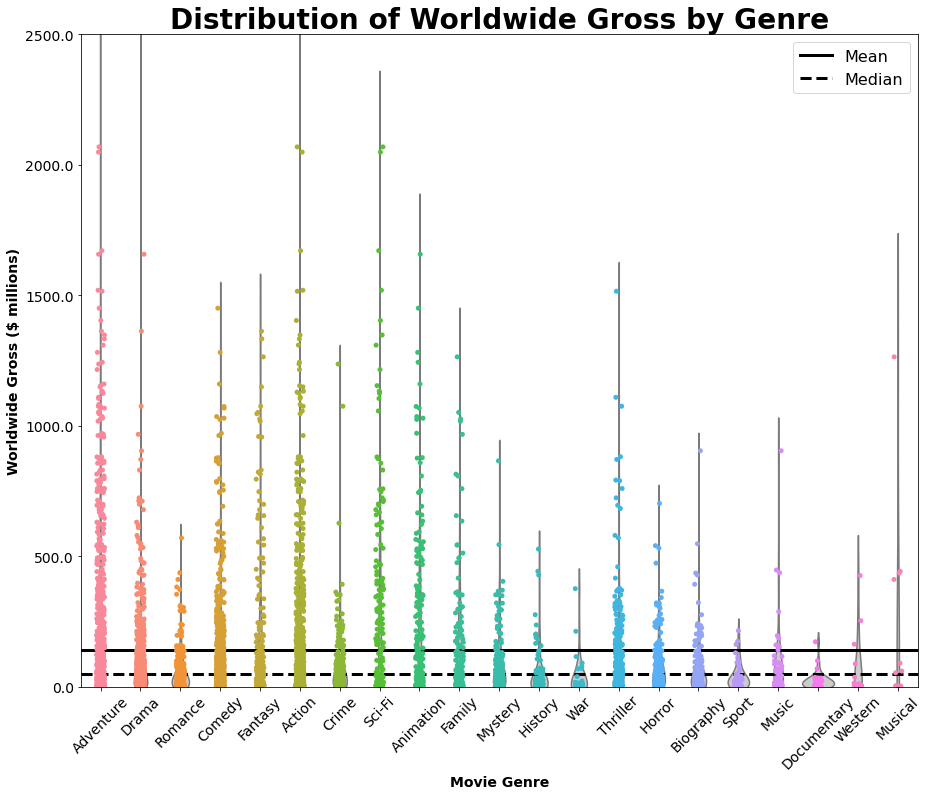

In [161]:
ax = sns.violinplot(x="genre_list", y="ww_gross1mil", data=financial_explode_genre,
                    inner=None, color=".8")
ax = sns.stripplot(x="genre_list", y="ww_gross1mil", data=financial_explode_genre)
ax.axhline(y=all_mean_wwg1mil, ls='-', c='k', linewidth=3, label='Mean')
ax.axhline(y=all_median_wwg1mil, ls='--', c='k', linewidth=3, label='Median')
ax.set(ylim=(0, 2500))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('Worldwide Gross ($ millions)', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of Worldwide Gross by Genre', fontsize=28, weight='bold')
plt.legend(fontsize=16)
ax.get_figure().set_size_inches((15,12))

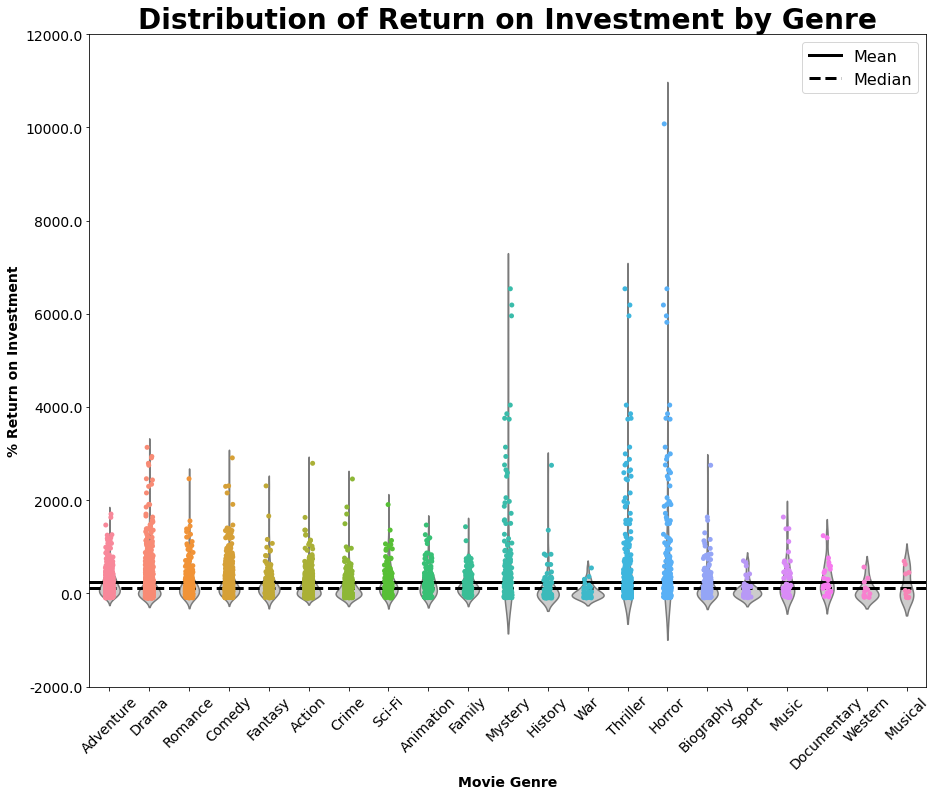

In [164]:
ax = sns.violinplot(x="genre_list", y="ROI", data=financial_explode_genre,
                    inner=None, color=".8")
ax = sns.stripplot(x="genre_list", y="ROI", data=financial_explode_genre)
ax.axhline(y=all_mean_ROI, ls='-', c='k', linewidth=3, label='Mean')
ax.axhline(y=all_median_ROI, ls='--', c='k', linewidth=3, label='Median')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('% Return on Investment', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of Return on Investment by Genre', fontsize=28, weight='bold')
plt.legend(fontsize=16)
ax.get_figure().set_size_inches((15,12))

In [165]:
all_genres_means = financial_explode_genre.groupby('genre_list').mean()
all_genres_means

,startYear,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,ROI,Sport,Biography,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
genre_list,,,,,,,,,,,,,,,,,,,,,
Action,2014.390671,6.263411,7.440798e+07,2.044380e+08,74.407974,204.438032,1.300300e+08,159.280554,0.010204,0.026239,...,1.000000,0.010204,0.043732,0.018950,0.013120,0.034985,0.001458,0.163265,0.444606,2.896501
Adventure,2014.654851,6.314552,9.007521e+07,3.074994e+08,90.075205,307.499515,2.174242e+08,211.407140,0.000000,0.020522,...,0.569030,0.001866,0.022388,0.117537,0.007463,0.009328,0.000000,0.149254,1.000000,2.960821
Animation,2014.548023,6.325424,7.259529e+07,2.690610e+08,72.595311,269.061073,1.964657e+08,230.676245,0.000000,0.011299,...,0.203390,0.000000,0.000000,0.146893,0.000000,0.000000,0.000000,0.005650,0.864407,2.949153
Biography,2014.930876,6.897696,2.333180e+07,6.166751e+07,23.331797,61.667419,3.833571e+07,169.764718,0.087558,1.000000,...,0.082949,0.009217,0.000000,0.041475,0.064516,0.170507,0.004608,0.000000,0.050691,2.815668
Comedy,2014.118890,6.093263,3.702805e+07,1.194165e+08,37.028045,119.416526,8.238842e+07,226.300280,0.009247,0.039630,...,0.158520,0.002642,0.018494,0.071334,0.207398,0.003963,0.002642,0.015852,0.243065,2.480845
Crime,2014.335347,6.312689,2.936633e+07,6.648528e+07,29.366344,66.485257,3.711895e+07,125.982404,0.000000,0.084592,...,0.489426,0.000000,0.027190,0.000000,0.009063,0.012085,0.000000,0.006042,0.066465,2.876133
Documentary,2013.142857,6.375000,6.303571e+06,2.467821e+07,6.303571,24.678571,1.837464e+07,305.337936,0.000000,0.071429,...,0.071429,0.035714,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.071429,1.821429
Drama,2014.199454,6.556102,3.057087e+07,7.315787e+07,30.570883,73.157842,4.258700e+07,195.446608,0.035519,0.180328,...,0.202186,0.024590,0.048270,0.035519,0.175774,0.090164,0.007286,0.033698,0.091075,2.632969
Family,2014.223077,6.126923,6.067385e+07,1.884364e+08,60.673846,188.436385,1.277626e+08,201.585653,0.015385,0.069231,...,0.100000,0.000000,0.000000,1.000000,0.007692,0.000000,0.007692,0.007692,0.484615,2.830769


In [166]:
all_genres_medians = financial_explode_genre.groupby('genre_list').median()
all_genres_medians

,startYear,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,ROI,Sport,Biography,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
genre_list,,,,,,,,,,,,,,,,,,,,,
Action,2014,6.30,40000000.0,81109917.5,40.0,81.110,35433044.5,92.054654,False,False,...,True,False,False,False,False,False,False,False,False,3
Adventure,2015,6.40,74500000.0,158615864.0,74.5,158.615,77858532.5,144.889950,False,False,...,True,False,False,False,False,False,False,False,True,3
Animation,2015,6.40,60000000.0,136454220.0,60.0,136.450,78885527.0,166.729008,False,False,...,False,False,False,False,False,False,False,False,True,3
Biography,2015,7.00,18000000.0,25035950.0,18.0,25.040,6242887.0,45.108473,False,True,...,False,False,False,False,False,False,False,False,False,3
Comedy,2014,6.20,21800000.0,49567466.0,21.8,49.570,25580920.0,138.293364,False,False,...,False,False,False,False,False,False,False,False,False,3
Crime,2014,6.40,22000000.0,29674699.0,22.0,29.670,5651333.0,43.123288,False,False,...,False,False,False,False,False,False,False,False,False,3
Documentary,2013,7.05,5000000.0,12040044.0,5.0,12.040,7040044.0,167.361627,False,False,...,False,False,False,False,False,False,False,False,False,2
Drama,2014,6.60,16000000.0,25179566.5,16.0,25.180,8295876.0,69.724376,False,False,...,False,False,False,False,False,False,False,False,False,3
Family,2014,6.30,39500000.0,94631916.5,39.5,94.630,52744032.5,131.872126,False,False,...,False,False,False,True,False,False,False,False,False,3


In [167]:
## create dataframe that summarizes mean values for ea genre
mean_group = financial_explode_genre.groupby('genre_list').mean()

## create dataframe that summarizes median values for ea genre
median_group = financial_explode_genre.groupby('genre_list').median()

In [168]:
## find the genres that have mean ww_gross above the median
mean_wwg_topHalf = mean_group.loc[mean_group['ww_gross1mil']>=mean_group['ww_gross1mil'].quantile(0.50)]
mean_wwg_topHalf.index

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [169]:
## find the genres that have median ww_gross above the median
median_wwg_topHalf = median_group.loc[median_group['ww_gross1mil']>=median_group['ww_gross1mil'].quantile(0.50)]
median_wwg_topHalf.index

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [170]:
## find the genres that have mean ROI above the median
mean_ROI_topHalf = mean_group.loc[mean_group['ROI']>=mean_group['ROI'].quantile(0.50)]
mean_ROI_topHalf.index

Index(['Adventure', 'Animation', 'Comedy', 'Documentary', 'Family', 'Horror',
       'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [171]:
## find the genres that have median ROI above the median
median_ROI_topHalf = median_group.loc[median_group['ROI']>=median_group['ROI'].quantile(0.50)]
median_ROI_topHalf.index

Index(['Adventure', 'Animation', 'Comedy', 'Documentary', 'Family', 'Fantasy',
       'Horror', 'Music', 'Mystery', 'Sci-Fi', 'Thriller'],
      dtype='object', name='genre_list')

In [172]:
## make a list of top genres by mean ww_gross
mean_wwg_topHalf_list = list(mean_wwg_topHalf.index)

## make a list of top genres by mean ROI
mean_ROI_topHalf_list = list(mean_ROI_topHalf.index)

## make a list of top genres by ww_gross
median_wwg_topHalf_list = list(median_wwg_topHalf.index)

## make a list of top genres by ROI
median_ROI_topHalf_list = list(median_ROI_topHalf.index)


## add the lists together and pick out the genres that fall in all categories
topH_genres = (mean_wwg_topHalf_list + mean_ROI_topHalf_list +
               median_wwg_topHalf_list + median_ROI_topHalf_list)
topH_counts = pd.Series(topH_genres).value_counts()
topH_counts

Mystery        4
Adventure      4
Animation      4
Sci-Fi         4
Comedy         4
Thriller       4
Horror         4
Family         4
Fantasy        3
Music          2
Documentary    2
Musical        2
Action         2
Romance        1
dtype: int64

In [173]:
## make a list of genres that fall in both categories (top ww gross and top ROI)
top_genres_list = list(topH_counts[:8].index)
print(top_genres_list)
len(top_genres_list)

['Mystery', 'Adventure', 'Animation', 'Sci-Fi', 'Comedy', 'Thriller', 'Horror', 'Family']


8

In [174]:
### only add movies to new df that fall into at least one of the top 8 genres
top_genres_df = med_financial_df.loc[(med_financial_df['Adventure'] == True) | 
                                 (med_financial_df['Mystery'] == True) |
                                 (med_financial_df['Animation'] == True) |
                                 (med_financial_df['Sci-Fi'] == True) |
                                 (med_financial_df['Thriller'] == True) |
                                 (med_financial_df['Comedy'] == True) |
                                 (med_financial_df['Horror'] == True) |
                                 (med_financial_df['Family'] == True)
                                ]
                               
display(top_genres_df.shape, top_genres_df.head())

(1628, 34)

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,numeratorROI,...,Action,War,Horror,Family,Romance,History,Musical,Sci-Fi,Adventure,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-1.538262e+07,...,False,False,False,False,True,False,False,False,True,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,9.813332e+07,...,False,False,False,False,False,False,False,False,False,3
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1.520401e+09,...,True,False,False,False,False,False,False,True,True,3
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-1.486504e+07,...,False,False,False,False,False,False,False,False,False,2
5,tt0377981,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,36000000.0,1.939677e+08,36.0,193.97,1.579677e+08,...,False,False,False,False,False,False,False,False,True,3


In [175]:
## drop genre columns from df that don't correspond to one of the top 8 genres
top_genres_df = top_genres_df.drop(['numeratorROI', 'Music', 'Musical', 'Crime', 'Fantasy', 'Western', 
               'Biography', 'History', 'War', 'Documentary', 'Sport', 
               'Romance', 'Drama', 'Horror', 'Action'], axis=1)
top_genres_df.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,ROI,genre_list,Thriller,Comedy,Mystery,Animation,Family,Sci-Fi,Adventure,genre_count
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-61.530492,"[Adventure, Drama, Romance]",False,False,False,False,False,False,True,3
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,109.037024,"[Comedy, Drama, Fantasy]",False,True,False,False,False,False,False,3
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,False,False,True,True,3
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-33.033427,"[Comedy, Drama]",False,True,False,False,False,False,False,2
5,tt0377981,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,36000000.0,1.939677e+08,36.0,193.97,438.799083,"[Adventure, Animation, Comedy]",False,True,False,True,False,False,True,3


In [176]:
top_genre_list = ['Adventure', 'Mystery', 'Animation', 'Sci-Fi', 'Thriller', 'Comedy', 'Horror', 'Family']

def fix_genre(genres):
    """ take in a string of genres, split it by commas into a list, and only append genres from 
    top_genre_list to a new list of genres
    Source for code: written by Sam Stoltenberg - github.com/skelouse
    """
    new_genres = []
    genres = genres.split(',')
    for g in genres:
        if g in top_genre_list:
            new_genres.append(g)
    return new_genres

In [177]:
## create a new col in the df that filters out all non-top genres from the genre list
top_genres_df['top_genre_list'] = top_genres_df['genres'].apply(lambda x: fix_genre(x))
display(top_genres_df.shape, top_genres_df.head())

(1628, 20)

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,ROI,genre_list,Thriller,Comedy,Mystery,Animation,Family,Sci-Fi,Adventure,genre_count,top_genre_list
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-61.530492,"[Adventure, Drama, Romance]",False,False,False,False,False,False,True,3,[Adventure]
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,109.037024,"[Comedy, Drama, Fantasy]",False,True,False,False,False,False,False,3,[Comedy]
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,False,False,True,True,3,"[Adventure, Sci-Fi]"
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-33.033427,"[Comedy, Drama]",False,True,False,False,False,False,False,2,[Comedy]
5,tt0377981,Gnomeo & Juliet,2011,"Adventure,Animation,Comedy",5.9,36000000.0,1.939677e+08,36.0,193.97,438.799083,"[Adventure, Animation, Comedy]",False,True,False,True,False,False,True,3,"[Adventure, Animation, Comedy]"


In [179]:
## explode the dataframe by this new top_genre_list col to be able to group by only top genres,
 ## not by all genres
explode_top_genres = top_genres_df.explode('top_genre_list') 
explode_top_genres.head()

,tconst,primaryTitle,startYear,genres,averageRating,budget,ww_gross,budget1mil,ww_gross1mil,ROI,genre_list,Thriller,Comedy,Mystery,Animation,Family,Sci-Fi,Adventure,genre_count,top_genre_list
0,tt0337692,On the Road,2012,"Adventure,Drama,Romance",6.1,25000000.0,9.617377e+06,25.0,9.62,-61.530492,"[Adventure, Drama, Romance]",False,False,False,False,False,False,True,3,Adventure
1,tt0359950,The Secret Life of Walter Mitty,2013,"Comedy,Drama,Fantasy",7.3,90000000.0,1.881333e+08,90.0,188.13,109.037024,"[Comedy, Drama, Fantasy]",False,True,False,False,False,False,False,3,Comedy
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,False,False,True,True,3,Adventure
3,tt0369610,Jurassic World,2015,"Action,Adventure,Sci-Fi",7.0,150000000.0,1.670401e+09,150.0,1670.40,1013.600425,"[Action, Adventure, Sci-Fi]",False,False,False,False,False,True,True,3,Sci-Fi
4,tt0376136,The Rum Diary,2011,"Comedy,Drama",6.2,45000000.0,3.013496e+07,45.0,30.13,-33.033427,"[Comedy, Drama]",False,True,False,False,False,False,False,2,Comedy


In [180]:
explode_top_genres.columns

Index(['tconst', 'primaryTitle', 'startYear', 'genres', 'averageRating',
       'budget', 'ww_gross', 'budget1mil', 'ww_gross1mil', 'ROI', 'genre_list',
       'Thriller', 'Comedy', 'Mystery', 'Animation', 'Family', 'Sci-Fi',
       'Adventure', 'genre_count', 'top_genre_list'],
      dtype='object')

In [358]:
top_genre_list

['Adventure',
 'Mystery',
 'Animation',
 'Sci-Fi',
 'Thriller',
 'Comedy',
 'Horror',
 'Family']

In [359]:
adventure_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Adventure']
mystery_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Mystery']
animation_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Animation']
scifi_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Sci-Fi']
thriller_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Thriller']
comedy_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Comedy']
horror_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Horror']
family_df = explode_top_genres.loc[explode_top_genres['top_genre_list']=='Family']

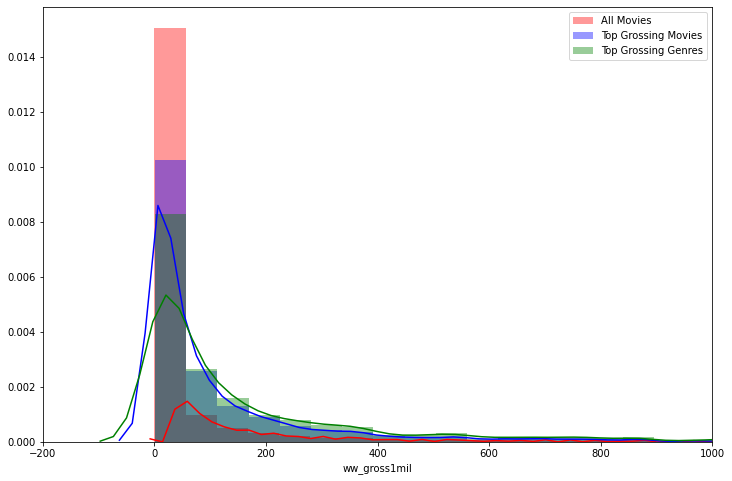

In [375]:
ax = sns.distplot(financial_dropna['ww_gross1mil'], color='r', label='All Movies')
ax = sns.distplot(med_financial_df['ww_gross1mil'], color='b', label='Top Grossing Movies')
ax = sns.distplot(explode_top_genres['ww_gross1mil'], color='g', label='Top Grossing Genres')
ax.set(xlim=(-200, 1000))
ax.get_figure().set_size_inches((12,8))
ax.legend()

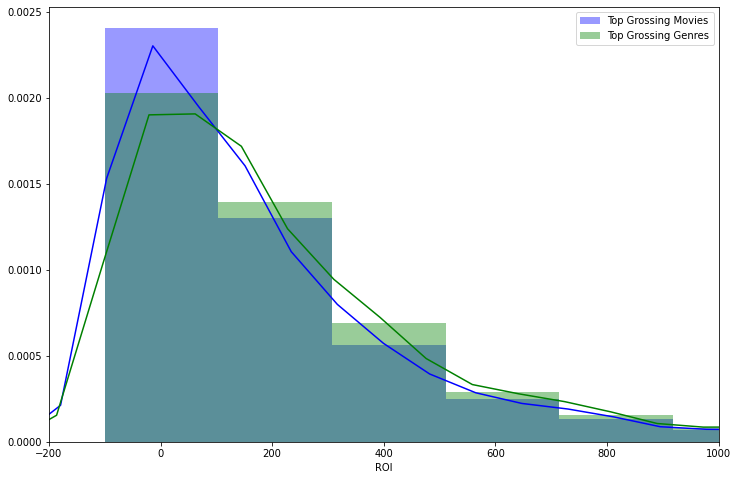

In [374]:
ax = sns.distplot(med_financial_df['ROI'], color='b', label='Top Grossing Movies')
ax = sns.distplot(explode_top_genres['ROI'], color='g', label='Top Grossing Genres')
ax.set(xlim=(-200, 1000))
ax.get_figure().set_size_inches((12,8))
ax.legend()

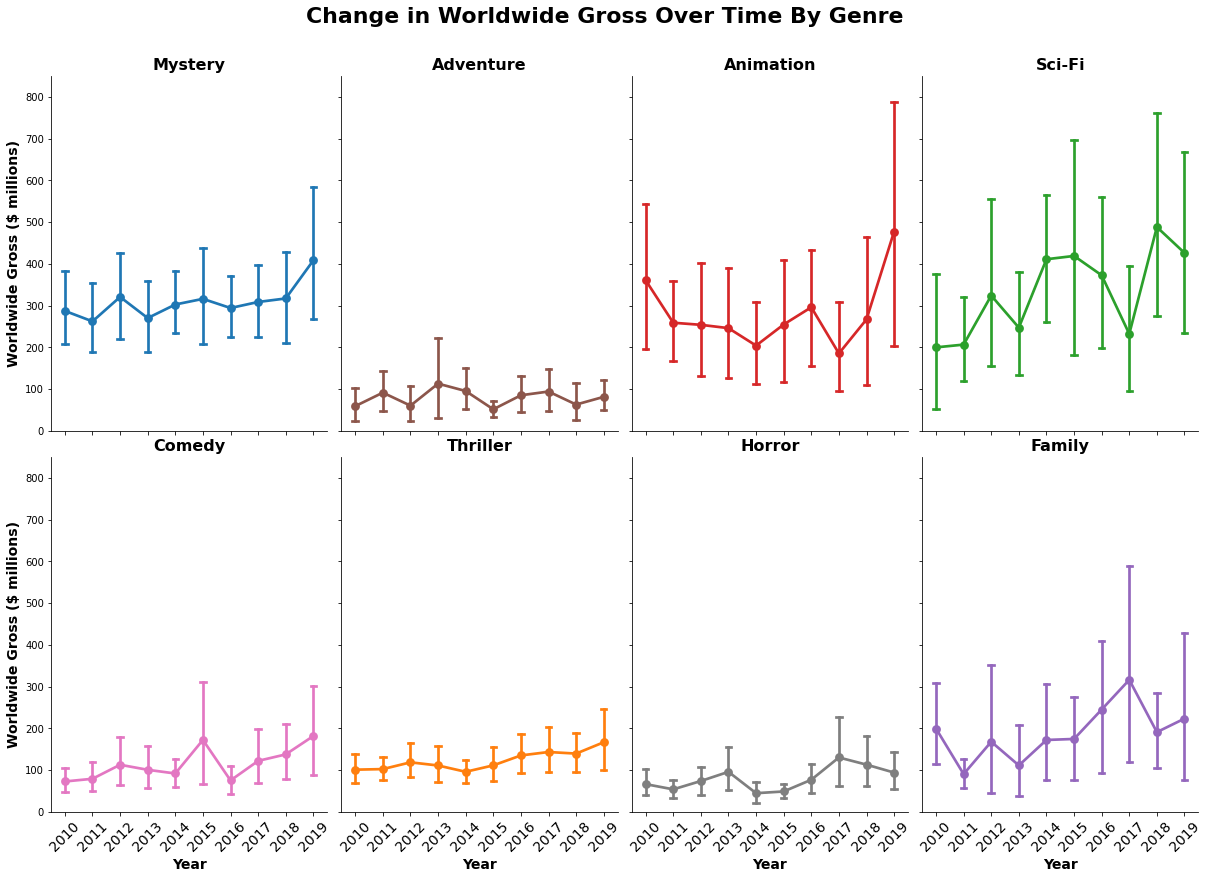

In [317]:
g = sns.catplot(x="startYear", y="ww_gross1mil", col="top_genre_list", col_wrap=4,
                capsize=.2, height=6, aspect=.7, col_order=top_genre_list,
                kind="point", hue="top_genre_list", data=explode_top_genres)

g.set(ylim=(0, 850))

axes = g.axes.flatten()
for i, genre in enumerate(top_genres_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')
    
axes[0].set_ylabel('Worldwide Gross ($ millions)', fontsize='14', weight='bold')
axes[4].set_ylabel('Worldwide Gross ($ millions)', fontsize='14', weight='bold')

for ax in axes[4:]:
    ax.set_xlabel('Year', fontsize='14', weight='bold')

g.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)

g.fig.suptitle("Change in Worldwide Gross Over Time By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

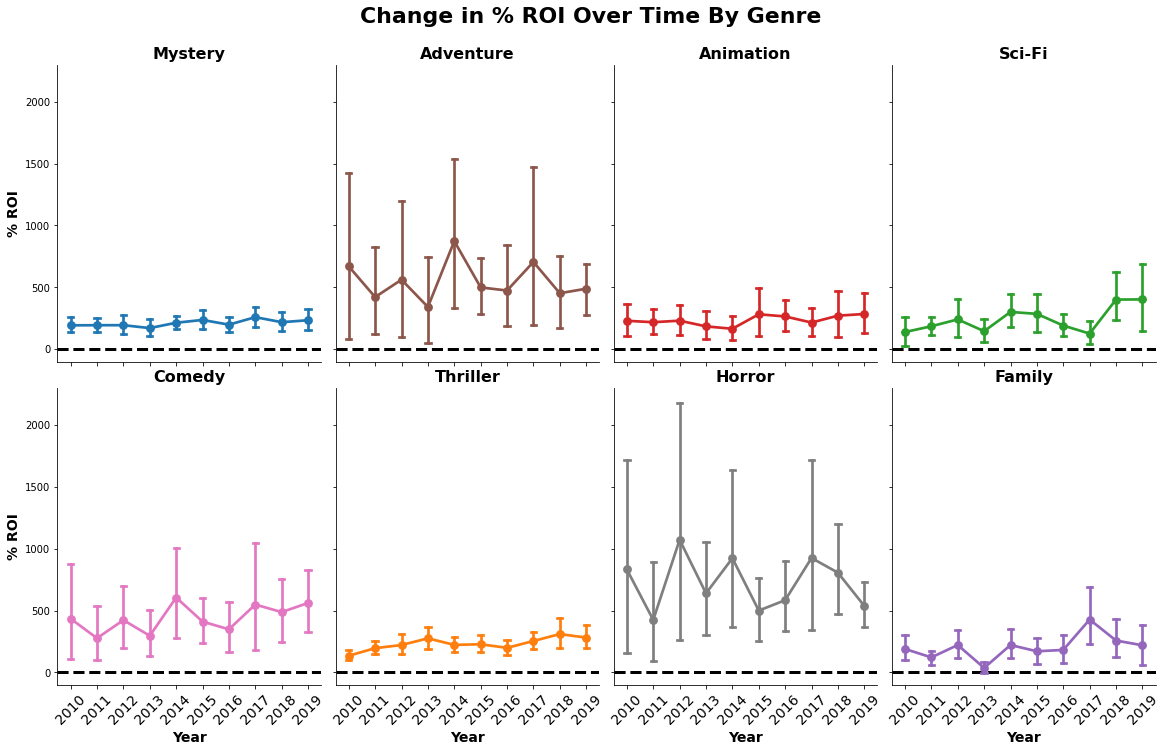

In [316]:
g = sns.catplot(x="startYear", y="ROI", col="top_genre_list", col_wrap=4,
                capsize=.2, height=5, aspect=.8, col_order=top_genre_list,
                kind="point", hue="top_genre_list", data=explode_top_genres)

g.map(plt.axhline, y=0, ls='--', c='k', linewidth=3).set(ylim=(-100, 2300))

axes = g.axes.flatten()
for i, genre in enumerate(top_genres_list):
    axes[i].set_title(genre, fontsize=16, weight='bold')

axes[0].set_ylabel('% ROI', fontsize='14', weight='bold')
axes[4].set_ylabel('% ROI', fontsize='14', weight='bold')

for ax in axes[4:]:
    ax.set_xlabel('Year', fontsize='14', weight='bold')

g.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)

g.fig.suptitle("Change in % ROI Over Time By Genre", size=22, weight='bold')
g.fig.subplots_adjust(top=.9)

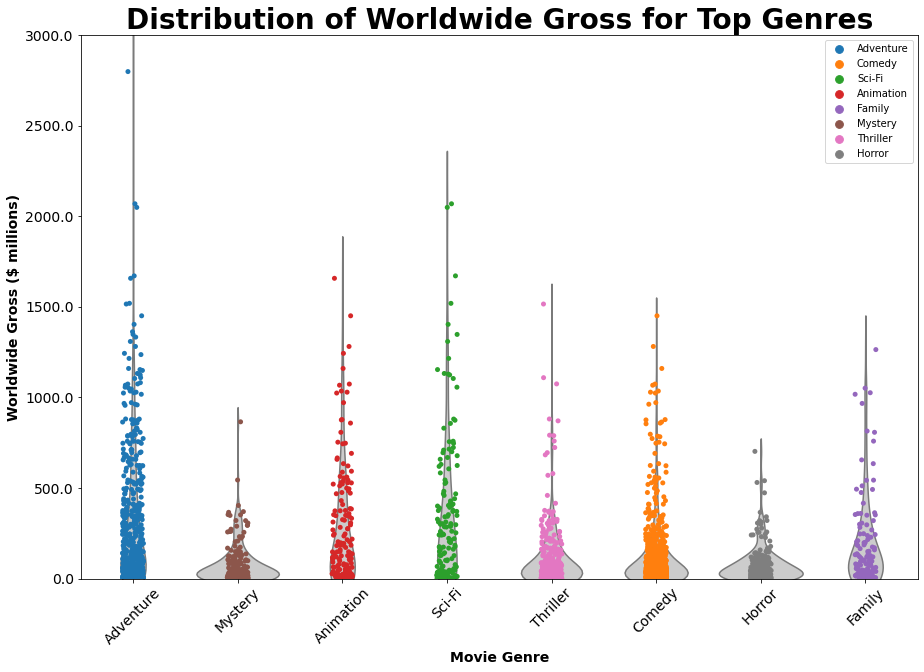

In [334]:
ax = sns.violinplot(x="top_genre_list", y="ww_gross1mil", order=top_genre_list,
                    data=explode_top_genres,
                    inner=None, color=".8")
ax = sns.stripplot(x='top_genre_list', y="ww_gross1mil", order=top_genre_list,
                data=explode_top_genres, hue="top_genre_list")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('Worldwide Gross ($ millions)', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set(ylim=(0, 3000))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of Worldwide Gross for Top Genres', fontsize=28, weight='bold')
ax.legend()
ax.get_figure().set_size_inches((15,10))

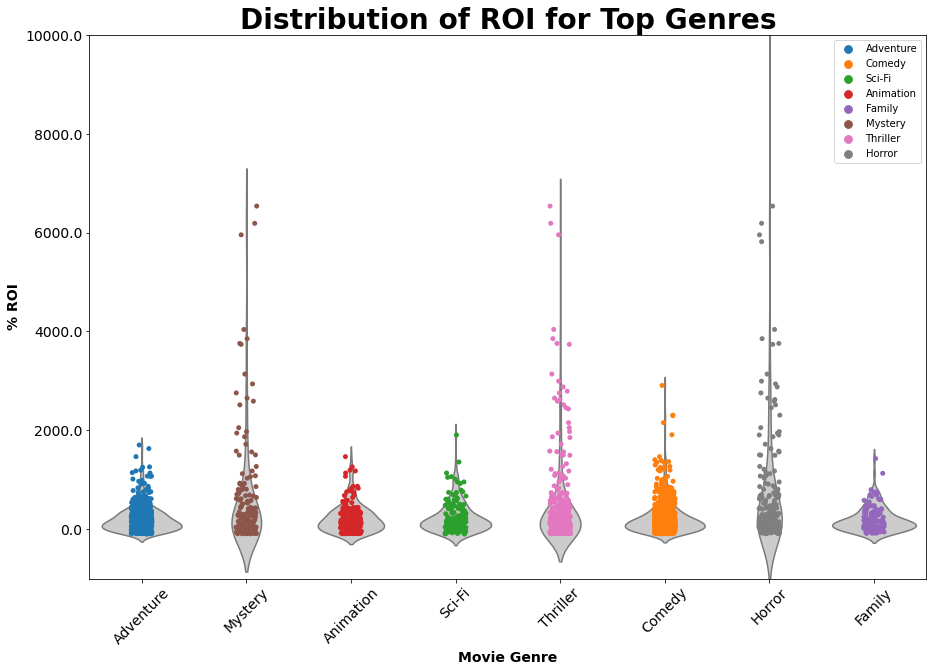

In [339]:
ax = sns.violinplot(x="top_genre_list", y="ROI", order=top_genre_list,
                    data=explode_top_genres,
                    inner=None, color=".8")
ax = sns.stripplot(x='top_genre_list', y="ROI", order=top_genre_list,
                data=explode_top_genres, hue="top_genre_list")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_xlabel('Movie Genre', fontsize=14, weight='bold')
ax.set_ylabel('% ROI', fontsize=14, weight='bold')
ax.set_yticks(ax.get_yticks())
ax.set(ylim=(-1000, 10000))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_title('Distribution of ROI for Top Genres', fontsize=28, weight='bold')
ax.legend()
ax.get_figure().set_size_inches((15,10))

In [186]:
explode_top_genres.columns

Index(['tconst', 'primaryTitle', 'startYear', 'genres', 'averageRating',
       'budget', 'ww_gross', 'budget1mil', 'ww_gross1mil', 'ROI', 'genre_list',
       'Thriller', 'Comedy', 'Mystery', 'Animation', 'Family', 'Sci-Fi',
       'Adventure', 'genre_count', 'top_genre_list'],
      dtype='object')

# Q2: Of the top grossing genres, how does movie budget affect return on investment?

In [73]:
# g = sns.lmplot(x="budget1mil", y="ww_gross1mil", col="top_genre_list", hue="top_genre_list", 
#                data=explode_top_genres, col_wrap=4, truncate=False, sharey=False)
# g.set(xlim=(0, 350), ylim=(0, 2500))

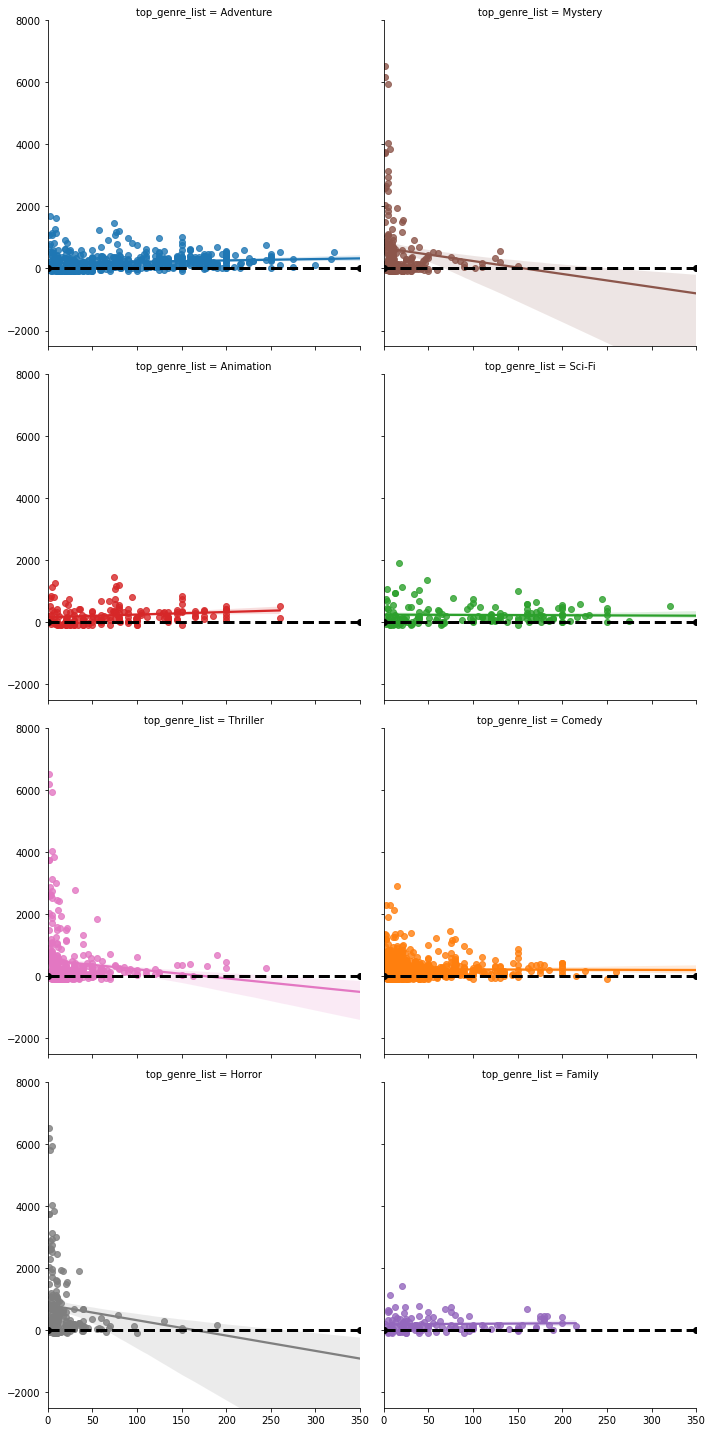

In [193]:
g = sns.lmplot(x="budget1mil", y="ROI", col="top_genre_list", hue="top_genre_list", 
               data=explode_top_genres, col_wrap=2, truncate=True, col_order=top_genre_list)
g.set(xlim=(0, 350), ylim=(-2500, 8000))
g.map(plt.axhline, y=0, ls='--', c='k', linewidth=3)

In [194]:
explode_top_genres.columns

Index(['tconst', 'primaryTitle', 'startYear', 'genres', 'averageRating',
       'budget', 'ww_gross', 'budget1mil', 'ww_gross1mil', 'ROI', 'genre_list',
       'Thriller', 'Comedy', 'Mystery', 'Animation', 'Family', 'Sci-Fi',
       'Adventure', 'genre_count', 'top_genre_list'],
      dtype='object')

# Q3: How does genre influence average movie rating?

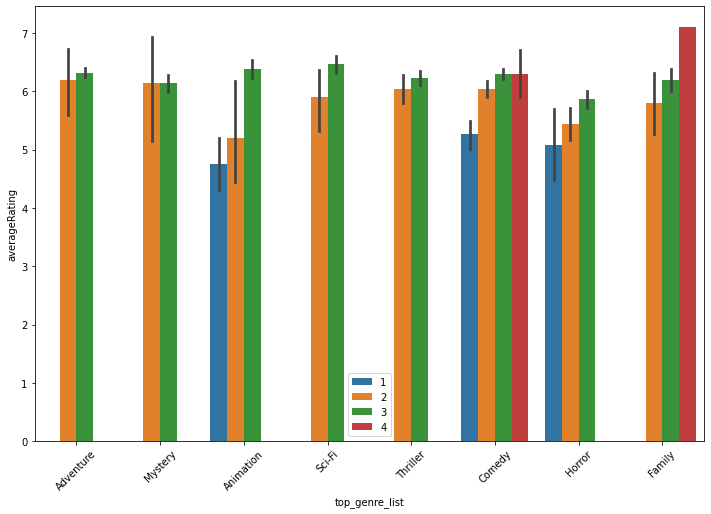

In [343]:
ax = sns.barplot(x='top_genre_list', y='averageRating', hue='genre_count',
                 data=explode_top_genres, order=top_genre_list)
ax.get_figure().set_size_inches((12,8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend()

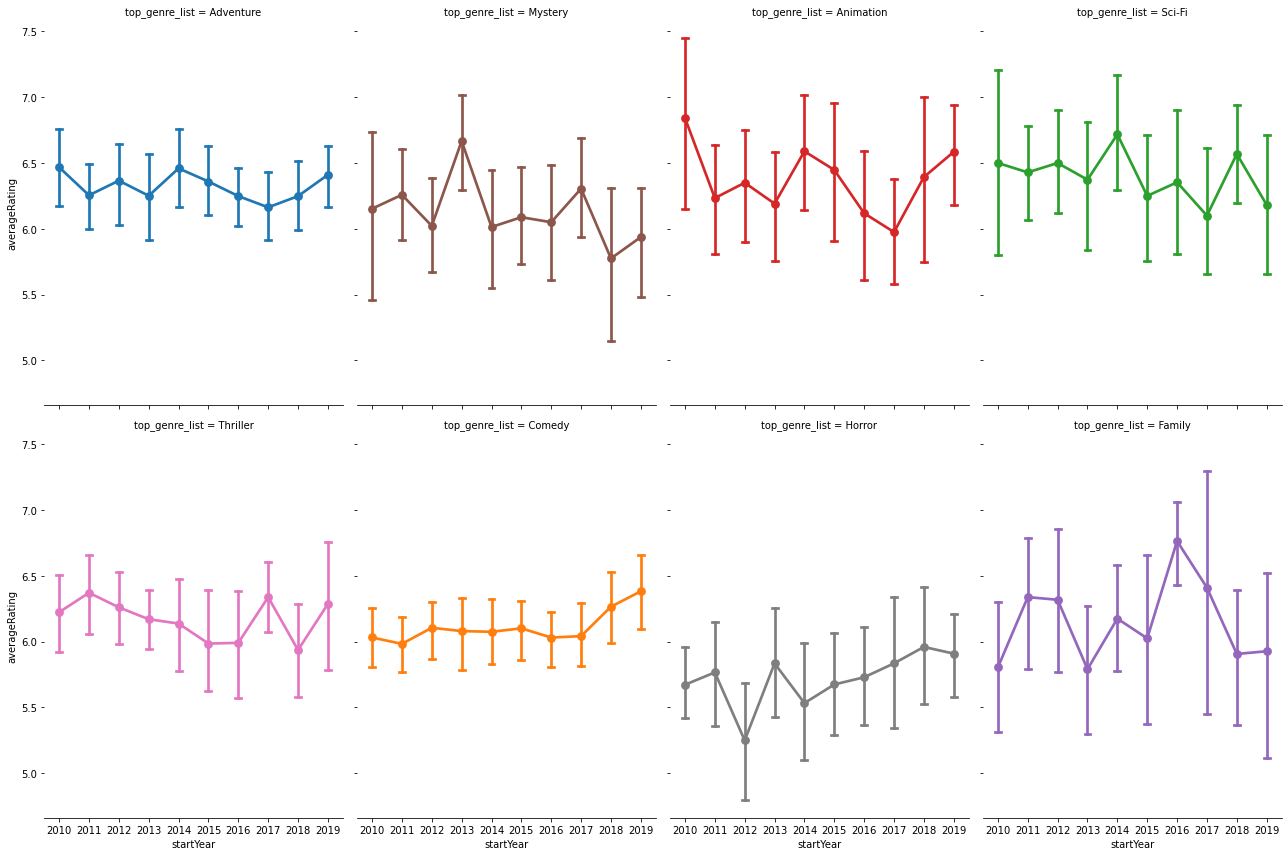

In [197]:
g = sns.catplot(x="startYear", y="averageRating", col="top_genre_list", col_wrap=4,
                capsize=.2, height=6, aspect=.75, col_order=top_genre_list, hue="top_genre_list", 
                kind="point", data=explode_top_genres)
g.despine(left=True)

# Conclusion and Recommendations

In [ ]:
fig = plt.figure(figsize=(8,8)) #matrix of correlation - red shows no correlation / blue shows high correlation plt.matshow(corr, cmap='RdBu', fignum=fig.number) plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical'); plt.yticks(range(len(corr.columns)), corr.columns); 

In [ ]:
sns.lmplot(x='budget1mil', y='ww_gross1mil', data=financial_dropna)